Import essential libraries

In [1]:
import numpy as np
import os
import copy
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from tqdm import trange
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

Unzip dataset (Dataset: https://www.kaggle.com/datasets/mehmetors/102-flower-dataset)

In [2]:
import tarfile

file = tarfile.open('/kaggle/input/102-flower-dataset/102flowers.tgz')

# extracting file
file.extractall('.')

file.close()

Load dataset and split into train, test, and validation sets

In [3]:
labels = loadmat('/kaggle/input/102-flower-dataset/imagelabels.mat')['labels'][0]
image_ids = np.arange(len(labels))

train_val_ids, test_ids = train_test_split(image_ids, test_size=0.2, stratify=labels, random_state=42)
train_ids, val_ids = train_test_split(train_val_ids, test_size=0.1, stratify=labels[train_val_ids], random_state=42)

train_ids.shape, val_ids.shape, test_ids.shape

((5895,), (656,), (1638,))

Define a custom pytorch dataset class to load images

In [4]:
class Oxford102Flowers(Dataset):
    def __init__(self, image_dir, ids, labels, transform=None):
        self.image_dir = image_dir
        self.ids = ids
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        image_id = self.ids[idx] + 1
        img_path = os.path.join(self.image_dir, f'image_{image_id:05d}.jpg')
        img = Image.open(img_path).convert("RGB")
        label = self.labels[self.ids[idx]] - 1 
        img = self.transform(img)

        return img, label

Load train, test, and validation subsets to DataLoaders

In [5]:
image_dir = '/kaggle/working/jpg'

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

baseline_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = Oxford102Flowers(image_dir, train_ids, labels)
val_dataset = Oxford102Flowers(image_dir, val_ids, labels, transform=baseline_transform)
test_dataset = Oxford102Flowers(image_dir, test_ids, labels, transform=baseline_transform)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512)
test_loader = DataLoader(test_dataset, batch_size=512)

train, test, and plotting functions for train_losses, val_losses, and accuracies

In [6]:
def train_epoch(model, dataloader, loss_fn, optimizer):
    model.train()
    train_loss = 0.0
    correct = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        correct += (outputs.argmax(dim=1) == labels).sum().item()

    avg_loss = train_loss / len(dataloader)
    accuracy = 100 * correct / len(dataloader.dataset)
    return avg_loss, accuracy

def evaluate_model(model, dataloader, loss_fn):
    model.eval()
    total_loss = 0.0
    correct = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()

            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / len(dataloader.dataset)
    return avg_loss, accuracy

def train_model(model, train_loader, val_loader, optimizer, n_epochs, patience=5):
    model.to(device)
    loss_fn = nn.CrossEntropyLoss()

    train_losses, val_losses = np.empty(n_epochs), np.empty(n_epochs)
    train_accuracies = np.empty(n_epochs)
    val_accuracies = np.empty(n_epochs)
    best_val_loss = float('inf')

    best_state = model.state_dict()
    patience_counter = 0

    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=int(patience / 2))

    current_lr = scheduler.get_last_lr()

    for epoch in (pbar := trange(n_epochs)):
        running_loss, running_train_acc = train_epoch(model, train_loader, loss_fn, optimizer)
        train_losses[epoch] = running_loss

        val_loss, running_val_acc = evaluate_model(model, val_loader, loss_fn)
        val_losses[epoch] = val_loss

        train_accuracies[epoch] = running_train_acc
        val_accuracies[epoch] = running_val_acc

        if patience:
            if epoch == 0 or val_losses[epoch] < best_val_loss - 1e-5:
                patience_counter = 0
                best_val_loss = val_losses[epoch]
                best_state = copy.deepcopy(model.state_dict())
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"\nEarly stopping at epoch {epoch+1}")
                    model.load_state_dict(best_state)
                    return train_losses[:epoch], val_losses[:epoch], train_accuracies[:epoch], val_accuracies[:epoch]

        pbar.set_description(f"Epoch {epoch+1} | Train Loss: {running_loss:.3f} | Validation Loss: {val_loss:.3f} | Train Accuracy: {running_train_acc:.3f} | Validation Accuracy: {running_val_acc:.3f} | Learning Rate: {scheduler.get_last_lr()} | Patience: {patience - patience_counter}")

        scheduler.step(val_loss)
        if scheduler.get_last_lr() != current_lr:
            print(f'Reducing learning rate to {scheduler.get_last_lr()}')
        current_lr = scheduler.get_last_lr()

    if patience:
        model.load_state_dict(best_state)

    return train_losses, val_losses, train_accuracies, val_accuracies

def test_model(model, loader):
    model.eval()
    model.to(device)

    correct = 0
    y_test, y_pred = [], []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)

            correct += (preds == labels).sum().item()
            y_test.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    acc = 100 * correct / len(loader.dataset)
    print(f'Test accuracy on {len(loader.dataset)} samples: {acc:.2f}%')

    return y_test, y_pred

def plot_training_curves(train_losses, val_losses, train_acc, val_acc):
    epochs = np.arange(1, len(train_losses) + 1)

    plt.figure(figsize=(14, 5))

    # Plot Losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', marker='o')
    plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='Train Accuracy', marker='o', color='green')
    plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy over Epochs')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

Create Simple CNN class

In [7]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=102, dropout=0.5):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # 224x224
            nn.ReLU(),
            nn.MaxPool2d(2),                             # 112x112

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),                             # 56x56

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),                             # 28x28

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))                 # 1x1
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 128), 
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

Create ResNet model class with dropout

In [8]:
class ResidualBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None, dropout=0.5):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout2d(p=dropout)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=102, dropout=0.5):
        super(ResNet, self).__init__()
        self.in_channels = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(block, 16, layers[0], stride=1, dropout=dropout)
        self.layer2 = self._make_layer(block, 32, layers[1], stride=2, dropout=dropout)
        self.layer3 = self._make_layer(block, 64, layers[2], stride=2, dropout=dropout)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride, dropout):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = [block(self.in_channels, out_channels, stride, downsample, dropout)]
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels, dropout=dropout))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

Create list of Simple CNN models to train and train models

Running experiment: Baseline (Simple CNN, Adam, No Optimizations)


Epoch 42 | Train Loss: 0.832 | Validation Loss: 1.900 | Train Accuracy: 73.418 | Validation Accuracy: 58.232 | Learning Rate: [0.001] | Patience: 4:  65%|██████▍   | 42/65 [27:26<14:58, 39.07s/it] 

Reducing learning rate to [0.0001]


Epoch 49 | Train Loss: 0.492 | Validation Loss: 1.809 | Train Accuracy: 85.632 | Validation Accuracy: 62.500 | Learning Rate: [0.0001] | Patience: 4:  75%|███████▌  | 49/65 [31:59<10:25, 39.07s/it] 

Reducing learning rate to [1e-05]


Epoch 52 | Train Loss: 0.463 | Validation Loss: 1.810 | Train Accuracy: 86.701 | Validation Accuracy: 62.805 | Learning Rate: [1e-05] | Patience: 1:  80%|████████  | 52/65 [34:36<08:39, 39.93s/it] 


Early stopping at epoch 53


Model accuracy on train dataset:
Test accuracy on 5895 samples: 84.77%
Model accuracy on val dataset:
Test accuracy on 656 samples: 61.74%
Model accuracy on test dataset:
Test accuracy on 1638 samples: 60.87%


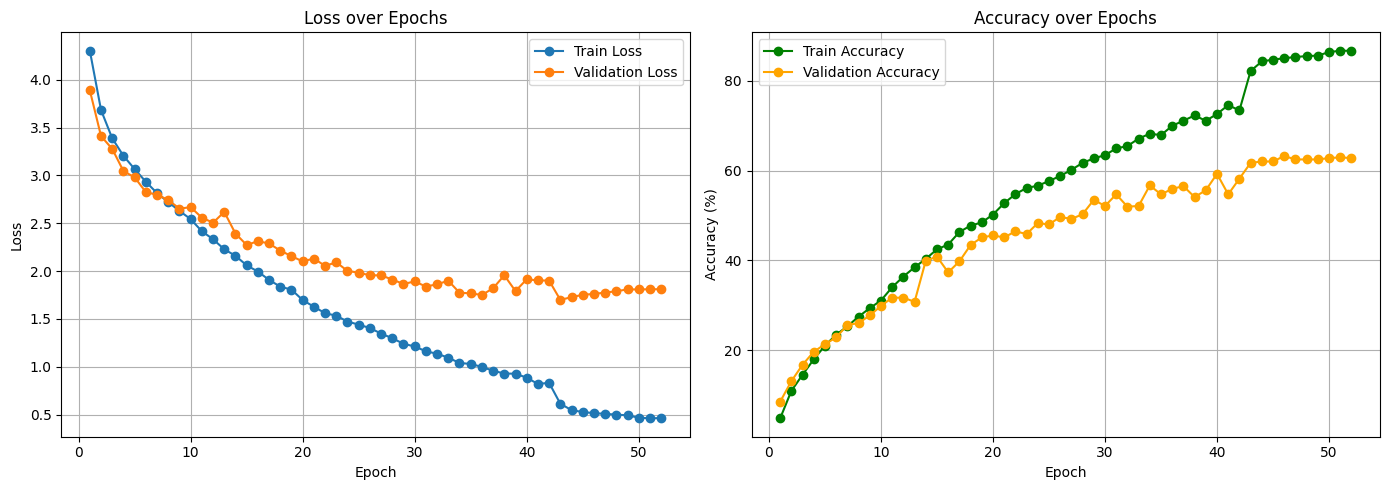

--------------------------------------------------------------------------------
Running experiment: Baseline Optimized (Simple CNN, Adam, Dropout 0.5)


Epoch 95 | Train Loss: 0.987 | Validation Loss: 1.324 | Train Accuracy: 69.415 | Validation Accuracy: 65.701 | Learning Rate: [0.001] | Patience: 4:  95%|█████████▌| 95/100 [1:04:24<03:22, 40.55s/it] 

Reducing learning rate to [0.0001]


Epoch 100 | Train Loss: 0.768 | Validation Loss: 1.307 | Train Accuracy: 75.335 | Validation Accuracy: 68.750 | Learning Rate: [0.0001] | Patience: 9: 100%|██████████| 100/100 [1:07:50<00:00, 40.70s/it]



Model accuracy on train dataset:
Test accuracy on 5895 samples: 89.86%
Model accuracy on val dataset:
Test accuracy on 656 samples: 68.29%
Model accuracy on test dataset:
Test accuracy on 1638 samples: 67.77%


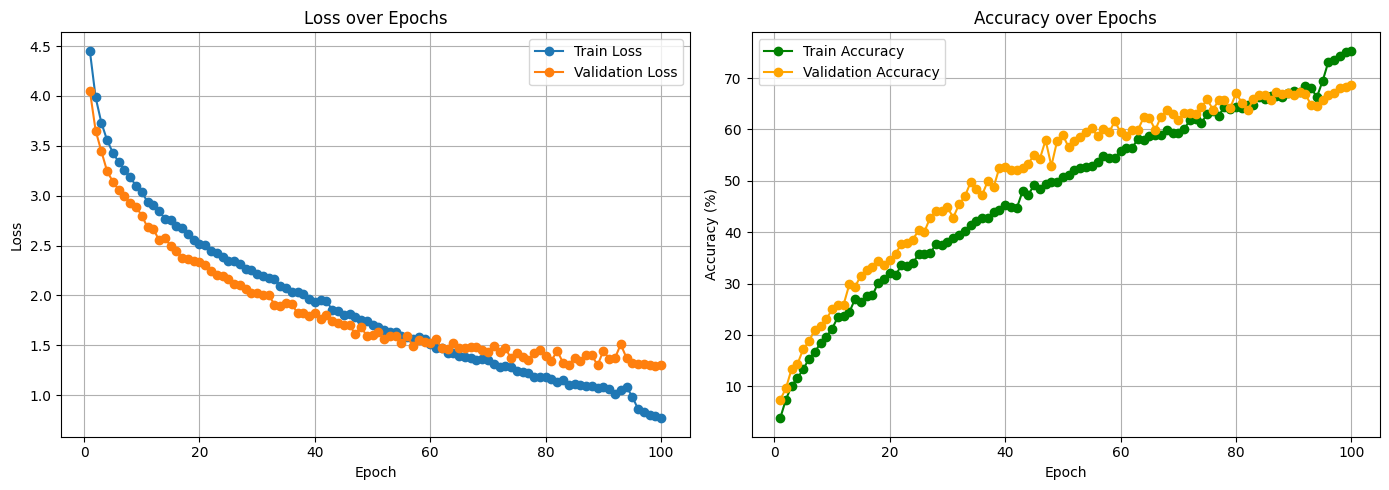

--------------------------------------------------------------------------------
Running experiment: Baseline Optimized (Simple CNN, Adam, Data Augmentation, Momentum 0.9)


Epoch 41 | Train Loss: 1.145 | Validation Loss: 1.762 | Train Accuracy: 66.158 | Validation Accuracy: 54.726 | Learning Rate: [0.001] | Patience: 4:  63%|██████▎   | 41/65 [35:00<20:12, 50.51s/it] 

Reducing learning rate to [0.0001]


Epoch 51 | Train Loss: 0.801 | Validation Loss: 1.613 | Train Accuracy: 76.217 | Validation Accuracy: 63.262 | Learning Rate: [0.0001] | Patience: 4:  78%|███████▊  | 51/65 [43:30<11:55, 51.12s/it] 

Reducing learning rate to [1e-05]


Epoch 54 | Train Loss: 0.763 | Validation Loss: 1.612 | Train Accuracy: 77.150 | Validation Accuracy: 62.043 | Learning Rate: [1e-05] | Patience: 1:  83%|████████▎ | 54/65 [46:55<09:33, 52.14s/it] 


Early stopping at epoch 55


Model accuracy on train dataset:
Test accuracy on 5895 samples: 76.08%
Model accuracy on val dataset:
Test accuracy on 656 samples: 62.80%
Model accuracy on test dataset:
Test accuracy on 1638 samples: 61.36%


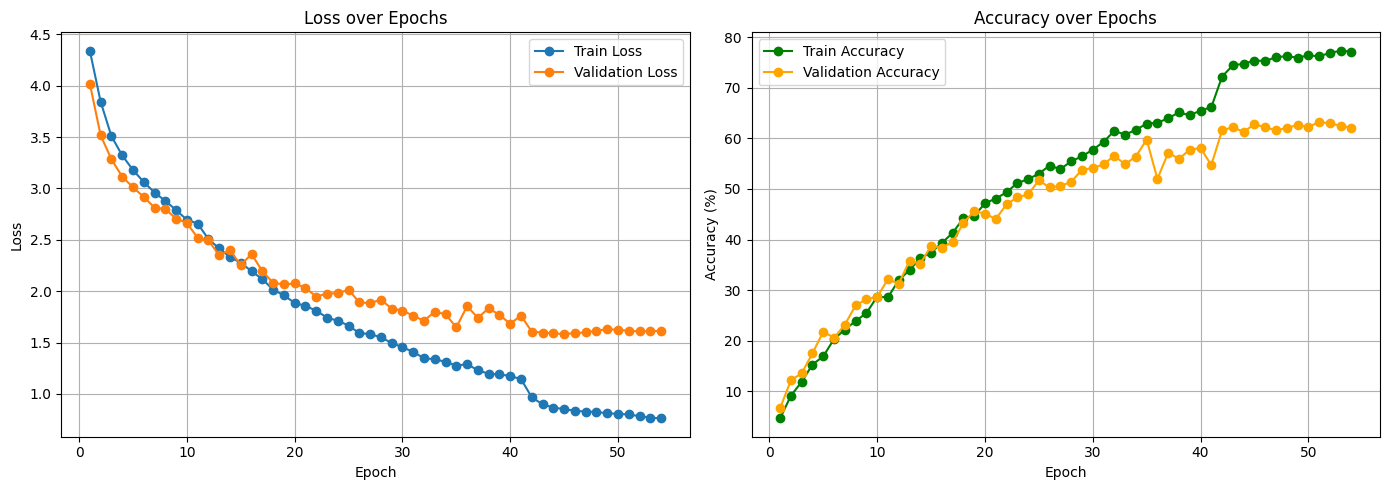

Running experiment: Baseline Optimized (Simple CNN, AdamW, Data Augmentation, Dropout 0.5)


Epoch 79 | Train Loss: 1.466 | Validation Loss: 1.462 | Train Accuracy: 57.303 | Validation Accuracy: 64.482 | Learning Rate: [0.001] | Patience: 4:  79%|███████▉  | 79/100 [1:07:48<17:58, 51.34s/it] 

Reducing learning rate to [0.0001]


Epoch 95 | Train Loss: 1.181 | Validation Loss: 1.387 | Train Accuracy: 64.411 | Validation Accuracy: 65.854 | Learning Rate: [0.0001] | Patience: 4:  95%|█████████▌| 95/100 [1:21:21<04:13, 50.61s/it] 

Reducing learning rate to [1e-05]


Epoch 98 | Train Loss: 1.160 | Validation Loss: 1.359 | Train Accuracy: 64.682 | Validation Accuracy: 65.091 | Learning Rate: [1e-05] | Patience: 1:  98%|█████████▊| 98/100 [1:24:43<01:43, 51.88s/it] 


Early stopping at epoch 99


Model accuracy on train dataset:
Test accuracy on 5895 samples: 77.79%
Model accuracy on val dataset:
Test accuracy on 656 samples: 66.62%
Model accuracy on test dataset:
Test accuracy on 1638 samples: 66.06%


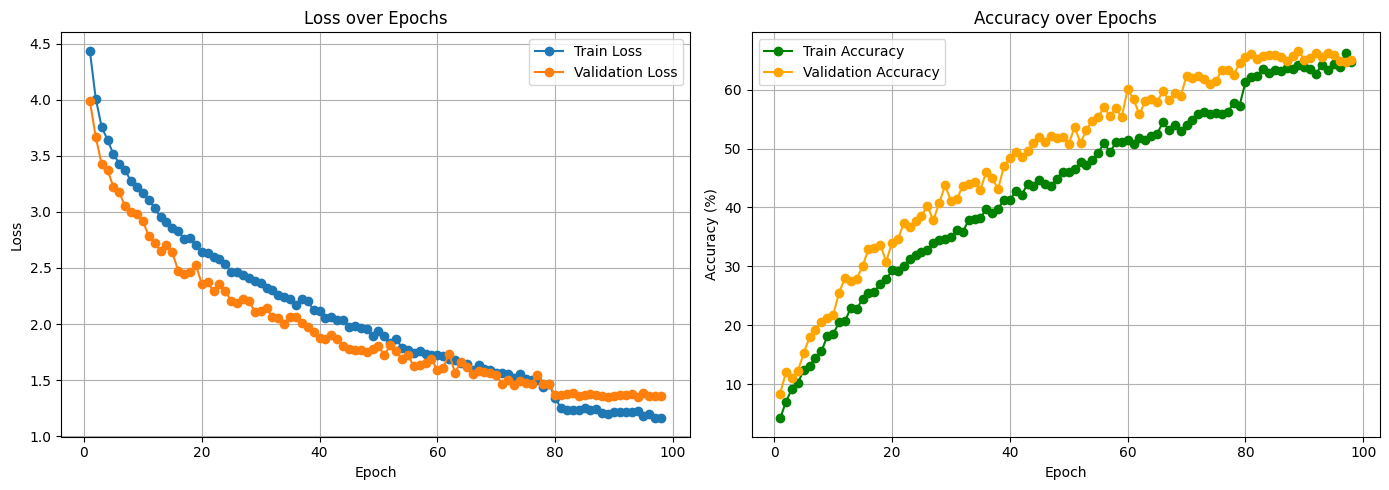

--------------------------------------------------------------------------------


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

configs = [
    {
        'title': 'Baseline (Simple CNN, Adam, No Optimizations)',
        'model_type': 'Simple',
        'optim': torch.optim.Adam,
        'lr': 1e-3,
        'mmnt': 0,
        'dout': 0,
        'epocs': 65,
        'patience': 10,
        'train_transform': baseline_transform
    },
    {
        'title': 'Baseline Optimized (Simple CNN, Adam, Dropout 0.5)',
        'model_type': 'Simple',
        'optim': torch.optim.Adam,
        'lr': 1e-3,
        'mmnt': 0,
        'dout': 0.5,
        'epocs': 100,
        'patience': 10,
        'train_transform': baseline_transform
    },
    {
        'title': 'Baseline Optimized (Simple CNN, Adam, Data Augmentation, Momentum 0.9)',
        'model_type': 'Simple',
        'optim': torch.optim.Adam,
        'lr': 1e-3,
        'mmnt': 0.9,
        'dout': 0,
        'epocs': 65,
        'patience': 10,
        'train_transform': train_transform
    },
    {
        'title': 'Baseline Optimized (Simple CNN, AdamW, Data Augmentation, Dropout 0.5)',
        'model_type': 'Simple',
        'optim': torch.optim.AdamW,
        'lr': 1e-3,
        'mmnt': 0,
        'dout': 0.5,
        'epocs': 100,
        'patience': 10,
        'train_transform': train_transform
    }
]

for config in configs:
    print(f"Running experiment: {config['title']}")

    train_dataset = Oxford102Flowers(image_dir, train_ids, labels, transform=config['train_transform'])
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

    # Initialize model
    if config['model_type'] == 'Simple':
        model = SimpleCNN(num_classes=102, dropout=config['dout']).to(device)
    else:
        model = ResNet(config['block'], config['layer'], num_classes=102, dropout=config['dout']).to(device)

    # Initialize optimizer
    optim_args = {'lr': config['lr']}
    if 'momentum' in config['optim'].__init__.__code__.co_varnames:
        optim_args['momentum'] = config['mmnt']
    optimizer = config['optim'](model.parameters(), **optim_args)

    # Train
    train_losses, val_losses, train_accuracies, val_accuracies = train_model(
        model,
        train_loader,
        val_loader,
        optimizer,
        n_epochs=config['epocs'],
        patience=config['patience']
    )

    print('Model accuracy on train dataset:')
    test_model(model, train_loader)

    print('Model accuracy on val dataset:')
    test_model(model, val_loader)

    print('Model accuracy on test dataset:')
    test_model(model, test_loader)

    plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies)
    print('-' * 80)

Create list of ResNet models to train and train models

Running experiment: ResNet 22 (Adam, No Optimization)


Epoch 49 | Train Loss: 0.945 | Validation Loss: 1.633 | Train Accuracy: 74.334 | Validation Accuracy: 58.994 | Learning Rate: [0.001] | Patience: 4:  65%|██████▌   | 49/75 [47:46<25:21, 58.53s/it]   

Reducing learning rate to [0.0001]


Epoch 71 | Train Loss: 0.661 | Validation Loss: 1.206 | Train Accuracy: 83.715 | Validation Accuracy: 69.817 | Learning Rate: [0.0001] | Patience: 4:  95%|█████████▍| 71/75 [1:09:15<03:55, 58.81s/it] 

Reducing learning rate to [1e-05]


Epoch 75 | Train Loss: 0.629 | Validation Loss: 1.166 | Train Accuracy: 84.682 | Validation Accuracy: 71.341 | Learning Rate: [1e-05] | Patience: 9: 100%|██████████| 75/75 [1:13:09<00:00, 58.53s/it] 



Model accuracy on train dataset:
Test accuracy on 5895 samples: 87.31%
Model accuracy on val dataset:
Test accuracy on 656 samples: 71.19%
Model accuracy on test dataset:
Test accuracy on 1638 samples: 72.41%


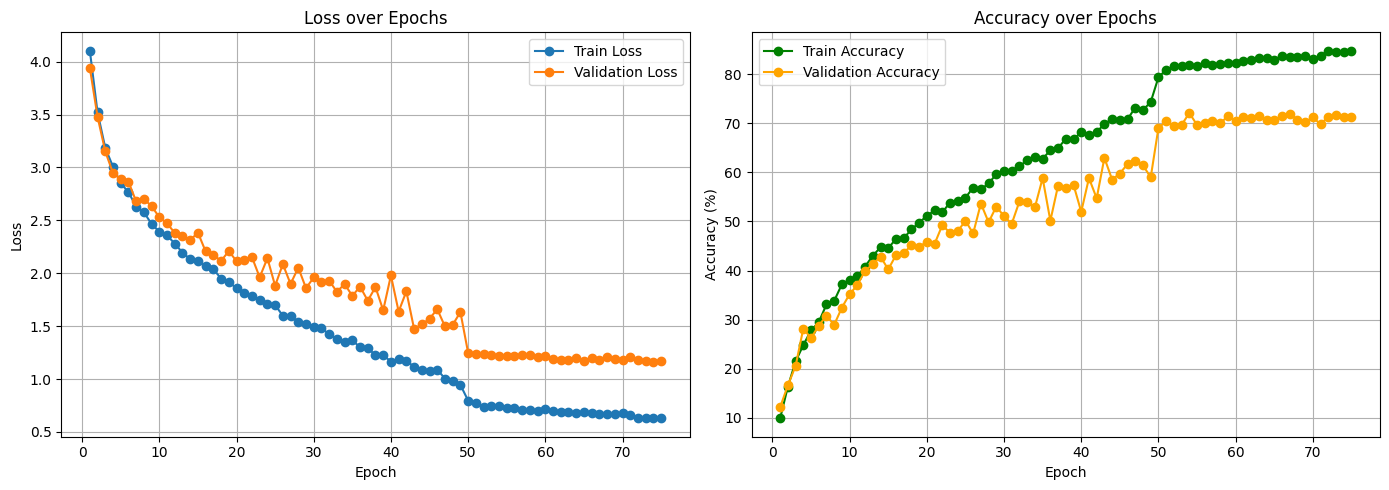

--------------------------------------------------------------------------------
Running experiment: ResNet 22 (Adam, Momentum 0.9)


Epoch 62 | Train Loss: 0.795 | Validation Loss: 1.403 | Train Accuracy: 78.372 | Validation Accuracy: 62.652 | Learning Rate: [0.001] | Patience: 4:  83%|████████▎ | 62/75 [1:01:58<13:02, 60.18s/it] 

Reducing learning rate to [0.0001]


Epoch 72 | Train Loss: 0.563 | Validation Loss: 1.050 | Train Accuracy: 86.921 | Validation Accuracy: 75.000 | Learning Rate: [0.0001] | Patience: 4:  96%|█████████▌| 72/75 [1:11:47<02:55, 58.58s/it] 

Reducing learning rate to [1e-05]


Epoch 75 | Train Loss: 0.537 | Validation Loss: 1.055 | Train Accuracy: 87.396 | Validation Accuracy: 74.848 | Learning Rate: [1e-05] | Patience: 1: 100%|██████████| 75/75 [1:14:42<00:00, 59.77s/it] 



Model accuracy on train dataset:
Test accuracy on 5895 samples: 88.24%
Model accuracy on val dataset:
Test accuracy on 656 samples: 75.61%
Model accuracy on test dataset:
Test accuracy on 1638 samples: 74.24%


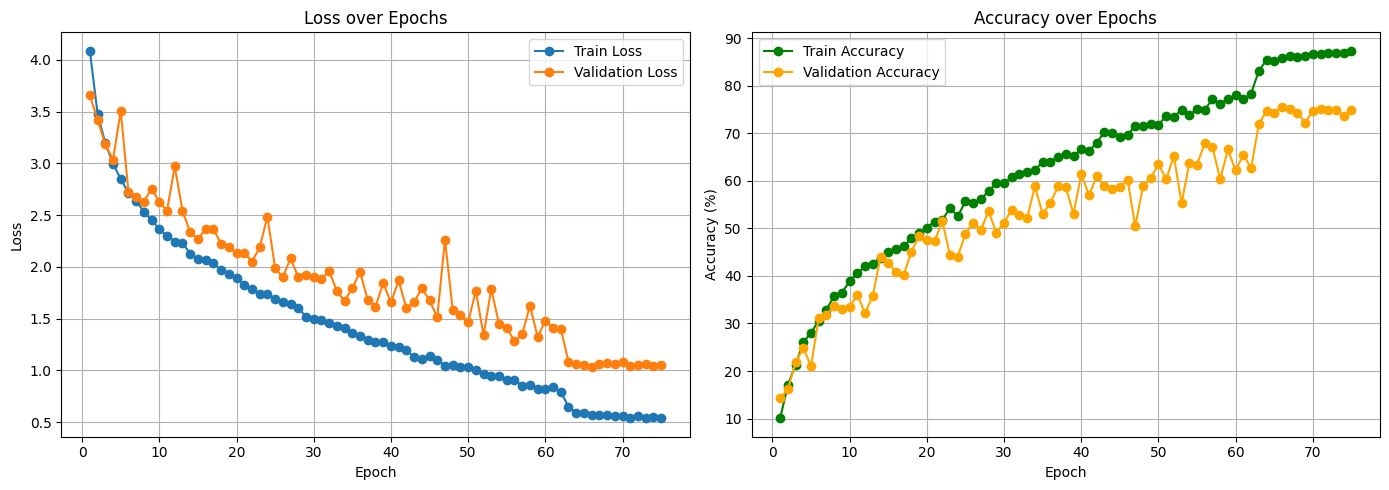

--------------------------------------------------------------------------------
Running experiment: ResNet 22 (Adam, Data Augmentation, Dropout 0.5)


Epoch 48 | Train Loss: 2.425 | Validation Loss: 2.409 | Train Accuracy: 37.795 | Validation Accuracy: 41.006 | Learning Rate: [0.001] | Patience: 4:  48%|████▊     | 48/100 [56:14<1:00:44, 70.10s/it] 

Reducing learning rate to [0.0001]


Epoch 78 | Train Loss: 2.253 | Validation Loss: 2.293 | Train Accuracy: 42.239 | Validation Accuracy: 41.616 | Learning Rate: [0.0001] | Patience: 4:  78%|███████▊  | 78/100 [1:31:31<26:00, 70.91s/it] 

Reducing learning rate to [1e-05]


Epoch 85 | Train Loss: 2.236 | Validation Loss: 2.292 | Train Accuracy: 42.154 | Validation Accuracy: 41.616 | Learning Rate: [1e-05] | Patience: 4:  85%|████████▌ | 85/100 [1:39:49<17:47, 71.13s/it] 

Reducing learning rate to [1.0000000000000002e-06]


Epoch 88 | Train Loss: 2.222 | Validation Loss: 2.282 | Train Accuracy: 42.545 | Validation Accuracy: 42.226 | Learning Rate: [1.0000000000000002e-06] | Patience: 1:  88%|████████▊ | 88/100 [1:44:32<14:15, 71.28s/it]


Early stopping at epoch 89


Model accuracy on train dataset:
Test accuracy on 5895 samples: 45.99%
Model accuracy on val dataset:
Test accuracy on 656 samples: 42.99%
Model accuracy on test dataset:
Test accuracy on 1638 samples: 44.08%


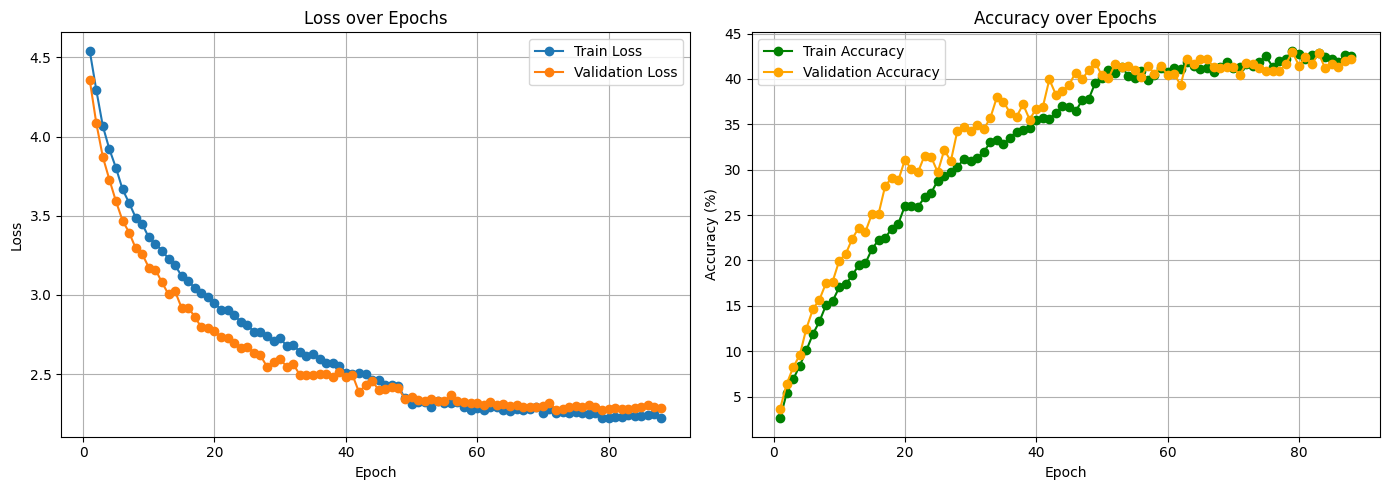

--------------------------------------------------------------------------------
Running experiment: ResNet 22 (AdamW, Data Augmentation, Dropout 0.5, Momentum 0.9)


Epoch 83 | Train Loss: 2.198 | Validation Loss: 2.201 | Train Accuracy: 42.511 | Validation Accuracy: 42.378 | Learning Rate: [0.001] | Patience: 4:  83%|████████▎ | 83/100 [1:38:27<20:08, 71.06s/it] 

Reducing learning rate to [0.0001]


Epoch 99 | Train Loss: 2.031 | Validation Loss: 2.119 | Train Accuracy: 46.022 | Validation Accuracy: 45.427 | Learning Rate: [0.0001] | Patience: 4:  99%|█████████▉| 99/100 [1:57:31<01:12, 72.38s/it]]

Reducing learning rate to [1e-05]


Epoch 100 | Train Loss: 2.010 | Validation Loss: 2.110 | Train Accuracy: 46.887 | Validation Accuracy: 44.207 | Learning Rate: [1e-05] | Patience: 3: 100%|██████████| 100/100 [1:58:44<00:00, 71.24s/it]



Model accuracy on train dataset:
Test accuracy on 5895 samples: 50.92%
Model accuracy on val dataset:
Test accuracy on 656 samples: 45.73%
Model accuracy on test dataset:
Test accuracy on 1638 samples: 48.05%


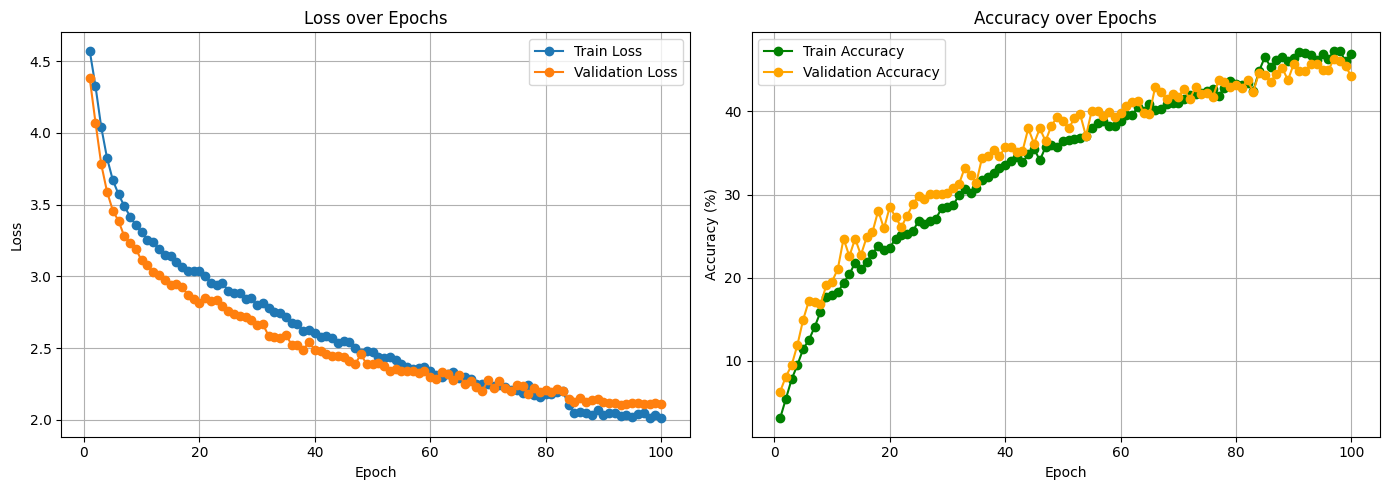

In [2]:
configs = [
    {
        'title': 'ResNet 22 (Adam, No Optimization)',
        'model_type': 'ResNet',
        'block': ResidualBlock,
        'layer': [3, 3, 3],
        'optim': torch.optim.Adam,
        'lr': 1e-3,
        'mmnt': 0,
        'dout': 0,
        'epocs': 75,
        'patience': 10,
        'train_transform': baseline_transform
    },
    {
        'title': 'ResNet 22 (Adam, Momentum 0.9)',
        'model_type': 'ResNet',
        'block': ResidualBlock,
        'layer': [3, 3, 3],
        'optim': torch.optim.Adam,
        'lr': 1e-3,
        'mmnt': 0.9,
        'dout': 0,
        'epocs': 75,
        'patience': 10,
        'train_transform': baseline_transform
    },
    {
        'title': 'ResNet 22 (Adam, Data Augmentation, Dropout 0.5)',
        'model_type': 'ResNet',
        'block': ResidualBlock,
        'layer': [3, 3, 3],
        'optim': torch.optim.Adam,
        'lr': 1e-3,
        'mmnt': 0,
        'dout': 0.5,
        'epocs': 100,
        'patience': 10,
        'train_transform': train_transform
    },
    {
        'title': 'ResNet 22 (AdamW, Data Augmentation, Dropout 0.5, Momentum 0.9)',
        'model_type': 'ResNet',
        'block': ResidualBlock,
        'layer': [3, 3, 3],
        'optim': torch.optim.AdamW,
        'lr': 1e-3,
        'mmnt': 0.9,
        'dout': 0.5,
        'epocs': 100,
        'patience': 10,
        'train_transform': train_transform
    }
]

for config in configs:
    print(f"Running experiment: {config['title']}")

    train_dataset = Oxford102Flowers(image_dir, train_ids, labels, transform=config['train_transform'])
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

    # Initialize model
    if config['model_type'] == 'Simple':
        model = SimpleCNN(num_classes=102, dropout=config['dout']).to(device)
    else:
        model = ResNet(config['block'], config['layer'], num_classes=102, dropout=config['dout']).to(device)

    # Initialize optimizer
    optim_args = {'lr': config['lr']}
    if 'momentum' in config['optim'].__init__.__code__.co_varnames:
        optim_args['momentum'] = config['mmnt']
    optimizer = config['optim'](model.parameters(), **optim_args)

    # Train
    train_losses, val_losses, train_accuracies, val_accuracies = train_model(
        model,
        train_loader,
        val_loader,
        optimizer,
        n_epochs=config['epocs'],
        patience=config['patience']
    )

    print('Model accuracy on train dataset:')
    test_model(model, train_loader)

    print('Model accuracy on val dataset:')
    test_model(model, val_loader)

    print('Model accuracy on test dataset:')
    test_model(model, test_loader)

    plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies)
    print('-' * 80)

Re-training best performing ResNet model with ResNet 56 (just for fun!)

Running experiment: ResNet 56 (Adam, Data Augmentation, Momentum 0.9)


Epoch 38 | Train Loss: 1.220 | Validation Loss: 1.801 | Train Accuracy: 66.243 | Validation Accuracy: 55.640 | Learning Rate: [0.001] | Patience: 2:  38%|███▊      | 38/100 [1:16:30<2:04:16, 120.27s/it]

Reducing learning rate to [0.0001]


Epoch 60 | Train Loss: 0.815 | Validation Loss: 1.060 | Train Accuracy: 77.761 | Validation Accuracy: 72.256 | Learning Rate: [0.0001] | Patience: 2:  60%|██████    | 60/100 [2:00:40<1:20:25, 120.63s/it]

Reducing learning rate to [1e-05]


Epoch 74 | Train Loss: 0.760 | Validation Loss: 1.041 | Train Accuracy: 79.864 | Validation Accuracy: 73.476 | Learning Rate: [1e-05] | Patience: 2:  74%|███████▍  | 74/100 [2:28:55<52:28, 121.09s/it]   

Reducing learning rate to [1.0000000000000002e-06]


Epoch 75 | Train Loss: 0.771 | Validation Loss: 1.036 | Train Accuracy: 79.796 | Validation Accuracy: 72.866 | Learning Rate: [1.0000000000000002e-06] | Patience: 1:  75%|███████▌  | 75/100 [2:32:56<50:58, 122.36s/it]


Early stopping at epoch 76
Model accuracy on train dataset:


Test accuracy on 5895 samples: 81.87%
Model accuracy on val dataset:
Test accuracy on 656 samples: 73.17%
Model accuracy on test dataset:
Test accuracy on 1638 samples: 72.59%


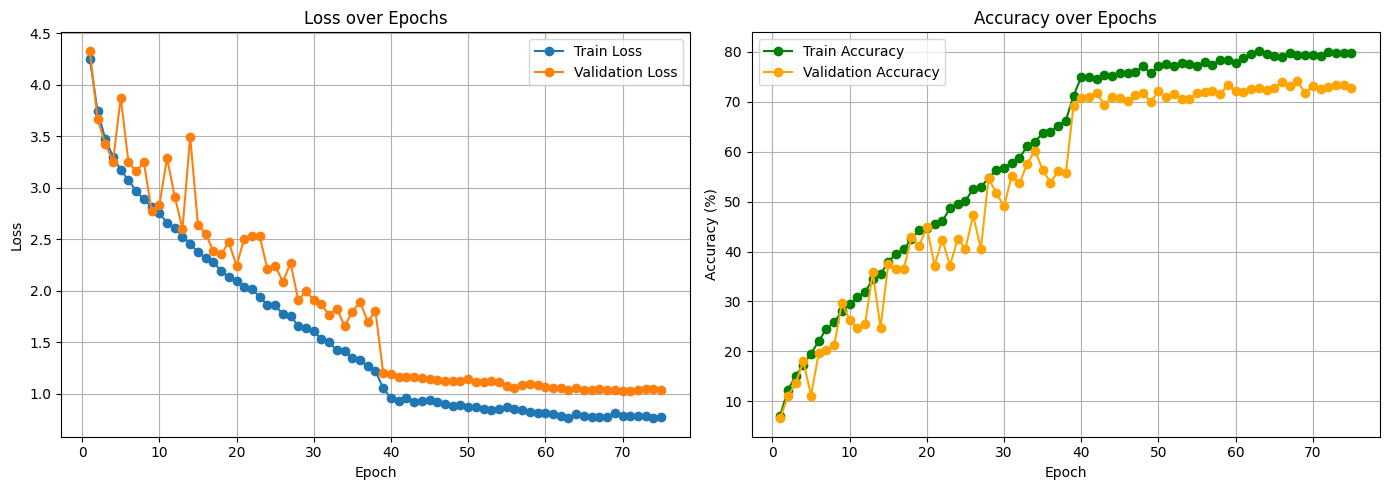

In [ ]:
configs = [
    {
        'title': 'ResNet 56 (Adam, Data Augmentation, Momentum 0.9)',
        'model_type': 'ResNet',
        'block': ResidualBlock,
        'layer': [9, 9, 9],
        'optim': torch.optim.Adam,
        'lr': 1e-3,
        'mmnt': 0.9,
        'dout': 0,
        'epocs': 100,
        'patience': 6,
        'train_transform': train_transform
    }
]

for config in configs:
    print(f"Running experiment: {config['title']}")

    train_dataset = Oxford102Flowers(image_dir, train_ids, labels, transform=config['train_transform'])
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

    # Initialize model
    if config['model_type'] == 'Simple':
        model = SimpleCNN(num_classes=102, dropout=config['dout'])
    else:
        model = ResNet(config['block'], config['layer'], num_classes=102, dropout=config['dout'])

    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs")
        model = nn.DataParallel(model)
    model = model.to(device)


    # Initialize optimizer
    optim_args = {'lr': config['lr']}
    if 'momentum' in config['optim'].__init__.__code__.co_varnames:
        optim_args['momentum'] = config['mmnt']
    optimizer = config['optim'](model.parameters(), **optim_args)

    # Train
    train_losses, val_losses, train_accuracies, val_accuracies = train_model(
        model,
        train_loader,
        val_loader,
        optimizer,
        n_epochs=config['epocs'],
        patience=config['patience']
    )

    print('Model accuracy on train dataset:')
    test_model(model, train_loader)

    print('Model accuracy on val dataset:')
    test_model(model, val_loader)

    print('Model accuracy on test dataset:')
    test_model(model, test_loader)

    plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies)

Epic Fail!!